In [1]:
%load_ext autoreload
%autoreload 2
!RUST_BACKTRACE=1 cargo run -- ../models/quadrotor.mo -t ../templates/sympy.jinja > quadrotor_sympy.py

    Finished ]8;;https://doc.rust-lang.org/cargo/reference/profiles.html#default-profiles\`dev` profile [unoptimized + debuginfo]]8;;\ target(s) in 0.09s
     Running `/home/jgoppert/git/rumoca/target/debug/rumoca ../models/quadrotor.mo -t ../templates/sympy.jinja`


If you are missing any packages run in a terminal:

```bash
sudo apt install ros-jazzy-tf-transformations python3-ipykernel python3-yaml
````

In [2]:
import quadrotor_sympy
import numpy as np
import matplotlib.pyplot as plt

model = quadrotor_sympy.Model()
model.solve()

def f_u(t):
    # aileron, elevator, rudder, throttle
    return np.array([0, 0, 0, 0.5])


model.f_x_dot(0, np.zeros(16), [], f_u(0), np.ones(24), np.ones(1, dtype=bool))

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0.5,
       0.5, 0.5, 0.5])

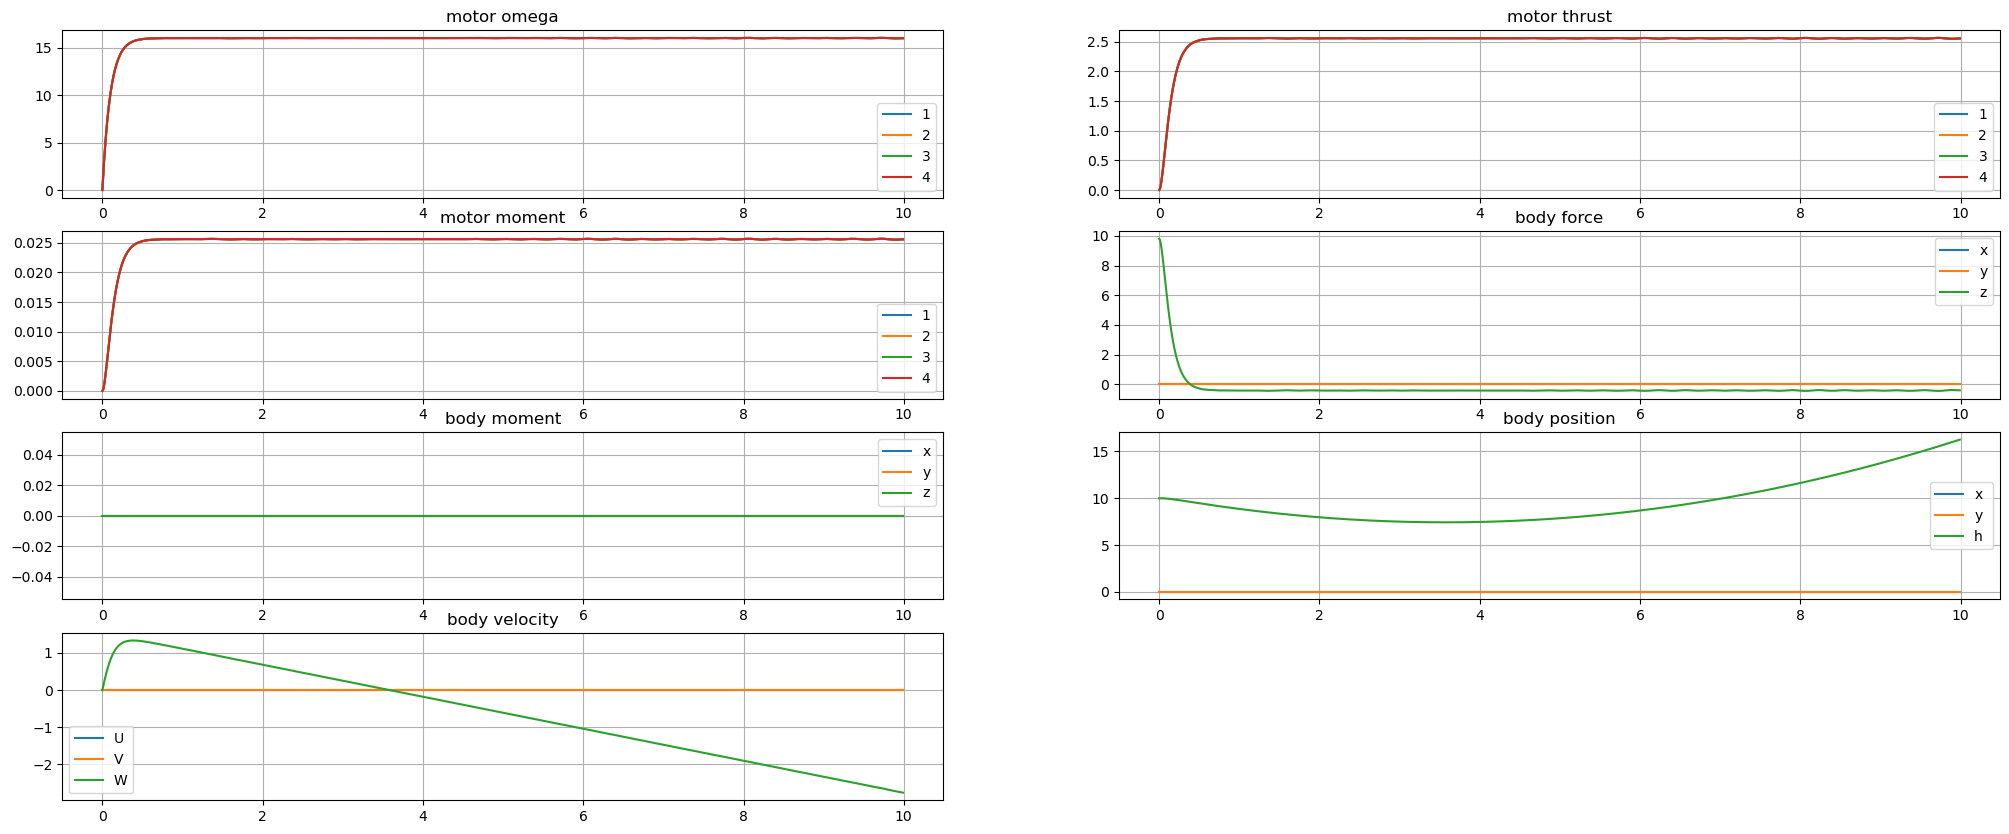

In [3]:
def sim_and_plotting(model, f_u):

    x0 = np.zeros(len(model.x))
    x0[model.x_index['h']] = 10
    model.p0['m_1_tau'] = 0.1
    model.p0['m_2_tau'] = 0.1
    model.p0['m_3_tau'] = 0.1
    model.p0['m_4_tau'] = 0.1

    res = model.simulate(t0=0, tf=10, dt=0.01, f_u=f_u, x0=x0)

    plt.figure(figsize=(25, 10))

    plt.subplot(4, 2, 1)
    plt.plot(res['t'], res['x'][12:16, :].T, label=['1', '2', '3', '4']);
    plt.grid()
    plt.title('motor omega')
    plt.legend()

    plt.subplot(4, 2, 2)
    plt.plot(res['t'], res['y'][[
            model.y_index['m_1_thrust'],
            model.y_index['m_2_thrust'],
            model.y_index['m_3_thrust'],
            model.y_index['m_4_thrust'],
        ], :].T, label=['1', '2', '3', '4']);
    plt.grid()
    plt.title('motor thrust')
    plt.legend()

    plt.subplot(4, 2, 3)
    plt.plot(res['t'], res['y'][[
            model.y_index['m_1_moment'],
            model.y_index['m_2_moment'],
            model.y_index['m_3_moment'],
            model.y_index['m_4_moment'],
        ], :].T, label=['1', '2', '3', '4']);
    plt.grid()
    plt.title('motor moment')
    plt.legend()

    plt.subplot(4, 2, 4)
    plt.plot(res['t'], res['y'][[
            model.y_index['F_x'],
            model.y_index['F_y'],
            model.y_index['F_z'],
        ], :].T, label=['x', 'y', 'z']);
    plt.grid()
    plt.title('body force')
    plt.legend()

    plt.subplot(4, 2, 5)
    plt.plot(res['t'], res['y'][[
            model.y_index['M_x'],
            model.y_index['M_y'],
            model.y_index['M_z'],
        ], :].T, label=['x', 'y', 'z'])
    plt.grid()
    plt.title('body moment')
    plt.legend()


    plt.subplot(4, 2, 6)
    plt.plot(res['t'], res['x'][[
            model.x_index['x'],
            model.x_index['y'],
            model.x_index['h'],
        ], :].T, label=['x', 'y', 'h '])
    plt.grid()
    plt.title('body position')
    plt.legend()

    plt.subplot(4, 2, 7)
    plt.plot(res['t'], res['x'][[
            model.x_index['U'],
            model.x_index['V'],
            model.x_index['W'],
        ], :].T, label=['U', 'V', 'W'])
    plt.grid()
    plt.title('body velocity')
    plt.legend()

sim_and_plotting(model, f_u)

In [4]:
def linearize(model):
    import control
    import sympy
    from IPython.display import display

    # linearization
    model.u0['a'] = 0
    model.u0['e'] = 0
    model.u0['r'] = 0
    model.u0['t'] = 1

    model.x0['m_1_omega'] = 16
    model.x0['m_2_omega'] = 16
    model.x0['m_3_omega'] = 16
    model.x0['m_4_omega'] = 16

    mode_x_dot = sympy.Matrix([xi for xi in model.sol_x_dot.subs(model.c0)])
    mode_y = sympy.Matrix([yi for yi in model.sol_y.subs(model.c0)])

    A = mode_x_dot.jacobian(model.x).subs(model.x0).subs(model.p0).subs(model.u0)
    B = mode_x_dot.jacobian(model.u).subs(model.x0).subs(model.p0).subs(model.u0)

    # output
    #C = mode_y.jacobian(model.x).subs(model.x0).subs(model.p0).subs(model.u0)
    #D = mode_y.jacobian(model.u).subs(model.x0).subs(model.p0).subs(model.u0)

    # state feedback
    C = np.eye(len(model.x))
    D = np.zeros((len(model.x), len(model.u)))

    sys = control.ss(A, B, C, D)
    tfm = control.ss2tf(sys)

    def clean_tf(G, tol):
        G = control.minreal(G, tol)
        return control.tf(np.where(np.abs(G.num) < 1e-10, 0, G.num), np.where(np.abs(G.den) < 1e-10, 0, G.den))

    G_h_t = clean_tf(tfm[model.x_index['h'], model.u_index['t']], 0.01)
    display(G_h_t)

    plt.figure(figsize=(12, 5))
    control.rlocus(G_h_t)

    plt.figure(figsize=(10, 5))
    control.bode(G_h_t)

try:
    linearize(model)
except ImportError as e:
    print("control library not installed, skipping linearization:" , e)
    pass

control library not installed, skipping linearization: No module named 'control'


Run the simulation:

In [5]:
import quadrotor_node

In [6]:
try:
    import quadrotor_node
except ImportError as e:
    print("quadrotor_node import error e, skipping ROS node", e)
    pass

In [7]:
quadrotor_node.run()

[INFO] [1760117622.990439856] [quadrotor_node]: Simulation started


ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6


[ERROR] [1760117624.475072797] [quadrotor_node]: Simulation error: Max events reached
[ERROR] [1760117624.666588121] [quadrotor_node]: Simulation error: Max events reached


ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6
ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6


[ERROR] [1760117624.864654949] [quadrotor_node]: Simulation error: Max events reached
[ERROR] [1760117625.064380694] [quadrotor_node]: Simulation error: Max events reached


ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6
ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6


[ERROR] [1760117625.258433950] [quadrotor_node]: Simulation error: Max events reached
[ERROR] [1760117625.447229117] [quadrotor_node]: Simulation error: Max events reached


ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6
ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6


[ERROR] [1760117625.641566824] [quadrotor_node]: Simulation error: Max events reached
[ERROR] [1760117625.836967175] [quadrotor_node]: Simulation error: Max events reached


ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6
ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6


[ERROR] [1760117626.029156834] [quadrotor_node]: Simulation error: Max events reached
[ERROR] [1760117626.228385372] [quadrotor_node]: Simulation error: Max events reached


ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6
ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6


[ERROR] [1760117626.416527648] [quadrotor_node]: Simulation error: Max events reached
[ERROR] [1760117626.609408332] [quadrotor_node]: Simulation error: Max events reached


ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6
ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6


[ERROR] [1760117626.808274398] [quadrotor_node]: Simulation error: Max events reached
[ERROR] [1760117627.001996975] [quadrotor_node]: Simulation error: Max events reached


ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6
ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6


[ERROR] [1760117627.196994359] [quadrotor_node]: Simulation error: Max events reached
[ERROR] [1760117627.390364097] [quadrotor_node]: Simulation error: Max events reached


ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6
ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6


[ERROR] [1760117627.585640162] [quadrotor_node]: Simulation error: Max events reached
[ERROR] [1760117627.778196637] [quadrotor_node]: Simulation error: Max events reached


ail: 0.0, elv: -0.0, rdr: 0.0, thr: 0.6
simulation finished


For visualization: In  another terminal run:

```bash
ros2 run rviz2 rviz2 --ros-args -p use_sim_time:=true
```

Add quadrotor_pose to view.


For control: In  another terminal run:

```bash
ros2 run joy joy_node --ros-args -p use_sim_time:=true
```